# Reproduce the Laplace-approximated NAM
## References
```  
@misc{bouchiat2023laplaceapproximated,
      title={Laplace-Approximated Neural Additive Models: Improving Interpretability with Bayesian Inference}, 
      author={Kouroche Bouchiat and Alexander Immer and Hugo Yèche and Gunnar Rätsch and Vincent Fortuin},
      year={2023},
      eprint={2305.16905},
      archivePrefix={arXiv},
      primaryClass={stat.ML}
}
```

In [2]:
import time 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import parameters_to_vector, vector_to_parameters

from LANAM.models import LaNAM, BayesianLinearRegression

from LANAM.trainer.training import *
from LANAM.trainer.nam_training import *
from LANAM.trainer.marglik_training import *
from LANAM.trainer.wandb_train import wandb_training

from LANAM.data.generator import *
from LANAM.data.toydataset import ToyDataset

from LANAM.config.default import defaults
from LANAM.utils.plotting import * 

import matplotlib.pyplot as plt 
import numpy as np


from laplace import Laplace
from laplace import marglik_training as lamt
from laplace.curvature.backpack import BackPackGGN

from nam.config import defaults as namDefaults
from nam.models import NAM
from nam.utils import *
from nam.data import NAMDataset

import wandb

In [3]:
%reload_ext autoreload 
%autoreload 2

In [4]:
wandb.login()
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: xinyu-zhang. Use `wandb login --relogin` to force relogin


0.7


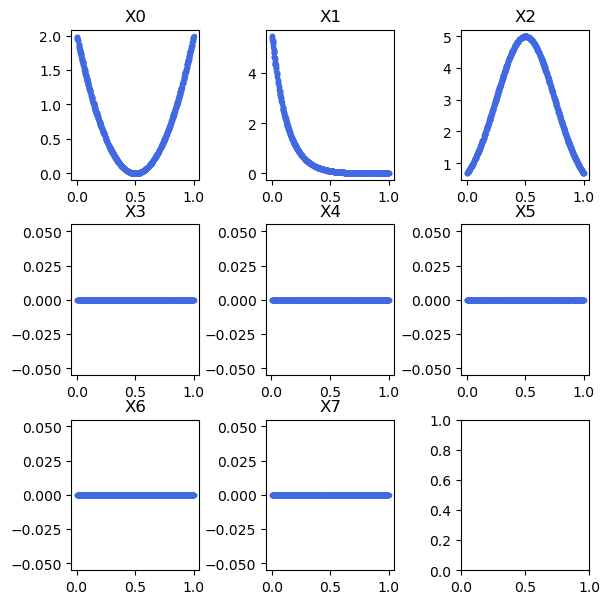

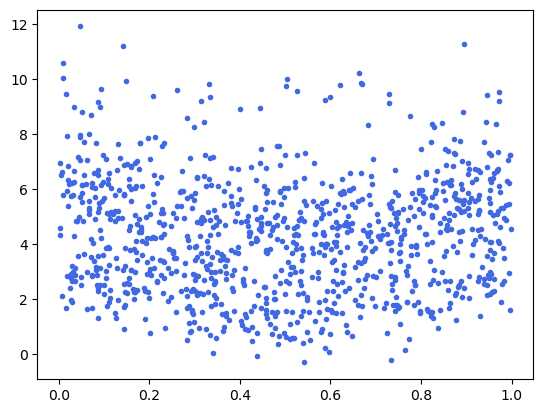

In [9]:
cfg = defaults()

gen_funcs, gen_func_names = sparse_task()
in_features = len(gen_funcs)
sigma = cfg.prior_sigma_noise
print(sigma)
trainset = ToyDataset(gen_funcs, gen_func_names, num_samples=1000, sigma=sigma)
valset = ToyDataset(gen_funcs, gen_func_names, num_samples=200, sigma=sigma)
testset = ToyDataset(gen_funcs, gen_func_names, num_samples=50, use_test=True)
trainset.plot()

train_loader, train_loader_fnn = trainset.loader, trainset.loader_fnn
val_loader, val_loader_fnn = valset.loader, valset.loader_fnn
X_test, y_test = testset.X, testset.y

In [10]:
# note that non-iterative type is invalid for wandb parameters_list
# note that log_uniform will add base exponents;
# while log_uniform_values expects specified values. 
"""parameters_list = {
    'lr': {
        'values': [0.1, 0.01, 0.001]
    }, 
    'lr_hyp': {
        'values': [0.1, 0.01, 0.001]
    }, 
    'n_epochs_burnin': {
        'values': [1, 20, 50]
    }, 
    'n_hypersteps': {
        'values': [30, 50, 70]
    }, 
    'marglik_frequency': {
        'values': [50, 100, 200]
    },
    'activation_cls': {
        'values': ['gelu', 'relu', 'elu', 'leakyrelu']
    }, 
}"""
parameters_list = {
    'lr': {
        'values': [0.01, 0.001]
    }, 
    'lr_hyp': {
        'values': [0.1, 0.01]
    }, 
    'activation_cls': {
        'values': ['gelu', 'relu', 'leakyrelu']
    }, 
    'hidden_sizes': {
        'values':[[64], [1024]] 
    }
}
sweep_configuration = {
    'method': 'grid', 
    'name': 'sweep',
    'parameters': parameters_list
}
# initialize the sweep 
sweep_id = wandb.sweep(
    sweep=sweep_configuration, 
    project='LANAM-test',
)
#sweep_id = 4wdr0f24
#print(f"sweep id: {sweep_id}")

Create sweep with ID: y8i0wexf
Sweep URL: https://wandb.ai/xinyu-zhang/LANAM-test/sweeps/y8i0wexf


In [ ]:
from functools import partial
wandb.agent(sweep_id, 
            function=partial(wandb_training, 
                             config=cfg, 
                             train_loader=train_loader, 
                             loader_fnn=train_loader_fnn,
                             testset=testset),
            count=1) # specify the maximum number of runs

In [14]:
lanams = dict()
acti_clses = ['gelu']
cfg.activation = True
cfg.hidden_sizes = [64]
for acti_cls in acti_clses:
    cfg.activation_cls = acti_cls
    print(f'LA-NAM with {acti_cls} activation unit: ')
    model = LaNAM(config=cfg, name=f'LA-NAM-{acti_cls}', in_features=in_features, hessian_structure='full', subset_of_weights='all', sigma_noise=0.2)
    print(model)
    model, margliks, losses, perfs = marglik_training(
    model, train_loader, train_loader_fnn, 'regression', optimizer_kwargs={'lr': 1e-2})
    lanams[acti_cls] = model

LA-NAM with gelu activation unit: 
LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0-7): 8 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
)
MARGLIK: finished training. Recover best model and fit Laplace.



 LA-NAM with gelu activation unit: 
-----------------
MSE loss:  0.0282
Additive sigma noise:  0.5205
Individual sigma noise: [0.0732365  0.10271554 0.09564999 0.05135116 0.04439773 0.05477673
 0.05281994 0.04552089]
Mean of additive predictive posterior std:  0.7231
Mean of individual predictive posterior std: [0.27134165 0.32150963 0.3104121  0.22693634 0.2109303  0.23444085
 0.2301606  0.21358408]


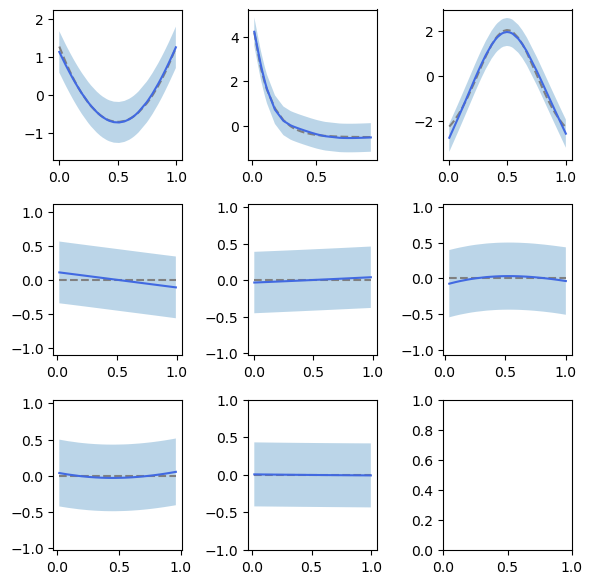

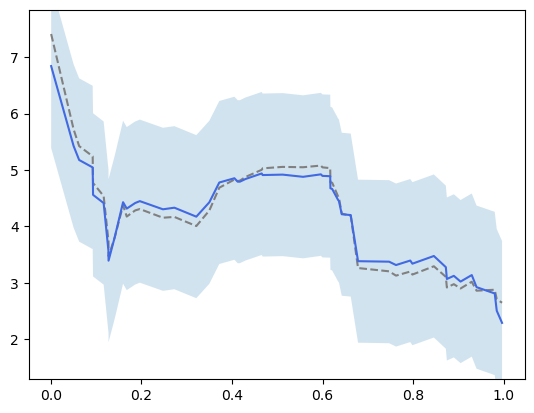

In [16]:
#X, y, fnn = testset.X, testset.y, testset.fnn
#fig, axs = plt.subplots(1, 4, figsize=(12, 3))
#axs = axs.ravel()
#fig.tight_layout()
for idx, acti_cls in enumerate(acti_clses):
    print(f'\n LA-NAM with {acti_cls} activation unit: ')
    print('-----------------')
    fig = plot_predictive_posterior(lanams[acti_cls], testset, uncertainty=True, sampling=False, plot_additive=True, plot_individual=True)
